In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util
import plot as sds_plt

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pyshtools
import pickle

comment = "SH30 run with synthetic observations based on swarm A with solution based on Cholesky decomposition. The semi-variogram is chosen to possible replicate histogram better."
nb_name = "nb_sh_core_swarm_A_sh30_chosolve_svsmall_normz500"

# Core

In [2]:
core = SDSS(comment, N_SH = 60, sim_type = "core", sat_height = 350)

core.grid_glq(nmax = 30, r_at = core.r_cmb)

grid_in = np.array([core.grid_glq_phi, 90-core.grid_glq_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = True)

In [3]:
core.generate_map()

<IPython.core.display.Javascript object>


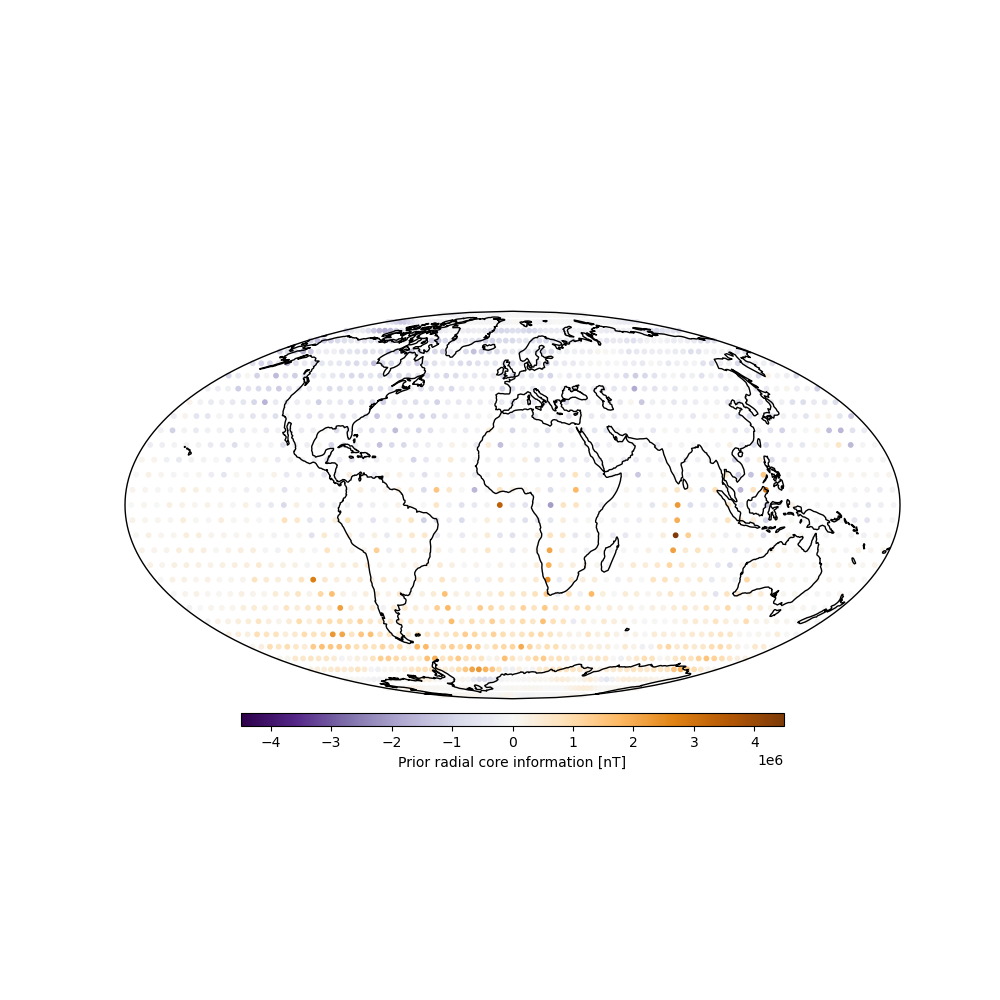

In [4]:
mt_util.plot_cartopy_global(lat = core.lat, lon = core.lon, plot_quality = "high", 
                            data=core.data, point_size=10, shift_grid = True, 
                            transpose_grid = True, shape = (121,61), cmap = 'PuOr_r', 
                            title="Prior radial core information")

In [5]:
core.condtab(normsize=500)

In [6]:
core.semivar(model_lags = 50, model = "exponential", max_dist = 5000, lag_length = 50, zero_nugget = True)

____semi-variogram setup___

Number of data used: 1574715
Max data distance: 4997.522 km
Lag length chosen: 50.0 km
Number of lags: 99
Number of modelling lags: 50

Semi-variogram model determined, starting LUT computation



In [7]:
#%% PLOT SEMI-VARIOGRAM
plt.figure(figsize=(10,8)) 
plt.plot(core.lags,core.pics,'o', markersize=10,color = '0.85',label='data semi-variogram')
plt.plot(core.lags_model,core.pics_model,'.',markersize=10,label='modelling data')
plt.plot(core.lags_sv_curve,core.sv_curve,color='C1',linewidth = 3,label='model')
plt.ylabel('Semi-variance $[%s^2]$' % "nT",fontsize=18,labelpad=18)
plt.xlabel('Lag [km]',fontsize=18,labelpad=18)
plt.title("Semi-variogram model of type: %s " % core.model_names[core.model],fontsize=18,y=1.02)
plt.legend(loc='best',fontsize=18)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.show()

<IPython.core.display.Javascript object>

In [8]:
print(core)


______current attributes______

a:                     6371.2
r_sat:                 6721.2
r_cmb:                 3480.0
rad:                   0.017453292519943295
mu0:                   1.2566370614359173e-06
comment:               SH30 run with synthetic observations based on swarm A with solution based on Cholesky decomposition. The semi-variogram is chosen to possible replicate histogram better.
class_abs_path:        /home/mikotz/spherical_direct_sequential_simulation
N_SH:                  60
sim_type:              core
grid_glq_zero:         (31,), Max/Min: 1.00 / -1.00
grid_glq_w_shtools:    (31,), Max/Min: 0.10 / 0.01
grid_glq_shape:        (2,), Max/Min: 61.00 / 31.00
grid_glq_w:            (1891,), Max/Min: 0.10 / 0.01
grid_glq_radial:       (1891,), Max/Min: 3480.00 / 3480.00
grid_glq_theta:        (1891,), Max/Min: 175.63 / 4.37
grid_glq_phi:          (1891,), Max/Min: 354.10 / 0.00
grid_glq_N:            1891
grid_glq_nmax:         30
r_grid:                3480.0
grid

# Synthetic sat

In [9]:
s_sat = SDSS(comment, N_SH = 60, sim_type = "sat", sat_height = 350)

s_sat.load_swarm("A")

grid_in = np.array([s_sat.swarm_phi, 90-s_sat.swarm_theta]).T
s_sat.make_grid(s_sat.swarm_radius, grid_in, calc_sph_d = False)

#s_sat.grid_equal_area(N_grid= 500, r_at = s_sat.r_sat, poles_remove = True)
#grid_in = np.array([s_sat.grid_eqa_phi, 90-s_sat.grid_eqa_theta]).T
#s_sat.grid(s_sat.r_sat, grid_in, calc_sph_d = False)

In [10]:
s_sat.generate_map(grid_type = "swarm")

In [11]:
mt_util.plot_cartopy_global(lat = s_sat.lat, lon = s_sat.lon, plot_quality = "high", point_size=5, 
                            data=s_sat.data, cmap = 'PuOr_r', title="Synthetic satellite data")

<IPython.core.display.Javascript object>

In [12]:
print(s_sat)


______current attributes______

a:                6371.2
r_sat:            6721.2
r_cmb:            3480.0
rad:              0.017453292519943295
mu0:              1.2566370614359173e-06
comment:          SH30 run with synthetic observations based on swarm A with solution based on Cholesky decomposition. The semi-variogram is chosen to possible replicate histogram better.
class_abs_path:   /home/mikotz/spherical_direct_sequential_simulation
N_SH:             60
sim_type:         sat
swarm_theta:      (2773,), Max/Min: 177.35 / 22.39
swarm_phi:        (2773,), Max/Min: 179.68 / -179.59
swarm_radius:     (2773,), Max/Min: 6825.19 / 6806.85
swarm_obs:        (2773,), Max/Min: 53117.43 / -48881.72
swarm_N:          2773
r_grid:           (2773,), Max/Min: 6825.19 / 6806.85
grid:             (2773, 2)
sph_d:            None
lon:              (2773,), Max/Min: 179.68 / -179.59
lat:              (2773,), Max/Min: 67.61 / -87.35
N_grid:           2773
B_ensemble_swarm: (2773, 3)
data:        

In [13]:
G_r = mt_util.Gr_vec(core.r_grid, s_sat.r_grid, core.lat, s_sat.lat, core.lon, s_sat.lon)
G_d = np.pi/(core.grid_glq_nmax+0.5)*np.multiply(core.grid_glq_w,G_r) # +0.5 for parity with SHTOOLS

In [14]:
plt.figure()
plt.imshow(G_d)
plt.colorbar()

<IPython.core.display.Javascript object>

In [15]:
# Compute forward and get residuals to synthetic observations
fwd_leg = G_d*core.data.reshape(-1,1)
fwd_leg_res = s_sat.data - fwd_leg.reshape(-1,)

# RMSE
rmse_leg = np.sqrt(np.mean(np.power(fwd_leg_res,2)))

print("")
print("Gauss-Legendre RMSE:\t %0.12f" %rmse_leg)
plt.figure()
y,binEdges=np.histogram(fwd_leg_res,bins=200)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'C0',label="Gauss-Legendre")
plt.xlabel("Radial field residuals [nT]")
plt.ylabel("Count")
plt.legend()
plt.show()


Gauss-Legendre RMSE:	 784.038340565152


<IPython.core.display.Javascript object>

In [16]:
errorstd = 3
errorvar = errorstd**2

def covmod_lsq_equiv(obs,semivar,target_var,G_d,title="",errorvar = 10e2):
    a_0 = np.empty([0,])
    b_0 = obs
    d_0 = b_0

    G = G_d.copy()
    C_M = target_var - semivar
    C_D = np.zeros((len(a_0)+len(b_0),len(a_0)+len(b_0)))
    C_D[np.arange(len(a_0)+1,len(a_0)+len(b_0)),np.arange(len(a_0)+1,len(a_0)+len(b_0))] = errorvar
    S = C_D + G*C_M*G.T
    T = np.linalg.inv(S)
    m_equiv_lsq = C_M*G.T*T*d_0
    lsq_equiv_pred = G_d*m_equiv_lsq
    lsq_equiv_res = obs - lsq_equiv_pred
    return m_equiv_lsq, lsq_equiv_pred, lsq_equiv_res

m_equiv_lsq, lsq_equiv_pred, lsq_equiv_res = covmod_lsq_equiv(s_sat.data.reshape(-1,1),core.sv_lut,core.target_var,G_d,title="Gauss-Legendre equivalent LSQ solution",errorvar = errorvar)

# RMSE
rmse_leg = np.sqrt(np.mean(np.power(lsq_equiv_res,2)))
print("")
print("Gauss-Legendre RMSE:\t %0.3f" %rmse_leg)
plt.figure()
y,binEdges=np.histogram(lsq_equiv_res,bins=200)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'C0',label="Gauss-Legendre")
plt.xlabel("Radial field residuals [nT]")
plt.ylabel("Count")
plt.legend()
plt.show()

#sds_util.plot_cartopy_global_new(core.lat, core.lon, data=np.ravel(m_equiv_lsq), plot_quality = "high", cmap = 'PuOr_r', title="Gauss-Legendre equivalent LSQ solution", scale_uneven = False)


Gauss-Legendre RMSE:	 0.336


<IPython.core.display.Javascript object>

In [17]:
mt_util.plot_cartopy_global(lat = core.lat, lon = core.lon, plot_quality = "high", 
                            data=np.ravel(m_equiv_lsq), point_size=10,
                            shape = (121,61), cmap = 'PuOr_r', 
                            title="Prior radial core information", limits_data = core.data)

<IPython.core.display.Javascript object>

In [18]:
#% SEMI-VARIOGRAM
plt.figure(figsize=(10,6))

#plt.plot(core.lags_model,core.pics_model,'.',markersize=10,label='modelling data')

plt.plot(core.lags_sv_curve,core.sv_curve,color='C1',label='SV model')

core.sv_zs(core.grid_glq_N,1,core.data.reshape(-1,1),core.sort_d,core.n_lags,core.max_cloud)
plt.plot(core.lags,core.pics_zs[:,0],'k--',label='Core prior')  

core.sv_zs(core.grid_glq_N,1,np.array(m_equiv_lsq),core.sort_d,core.n_lags,core.max_cloud)
plt.plot(core.lags,core.pics_zs[:,0],color = 'C3',label='Seqsim equiv. LSQ')    

#core.sv_zs(core.grid_glq_N,1,data_lstsq["data"].reshape(-1,1),core.sort_d,core.n_lags,core.max_cloud)
#plt.plot(core.lags,core.pics_zs[:,0],color = 'C4',label='LSQ')  

#plt.plot(core.lags,core.pics,'o', markersize=10,color = '0.85',label='Core field estimate')


plt.ylabel('Semi-variance $[%s^2]$' % "nT",fontsize=18,labelpad=18)
plt.xlabel('Lag [km]',fontsize=18,labelpad=18)
plt.legend(loc='best',fontsize=18)
plt.show()

#% HISTOGRAM
plt.figure(figsize=(10,6))    

y,binEdges=np.histogram(core.data,bins=50,density=False)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'k--',label='Core prior')

y,binEdges=np.histogram(np.array(m_equiv_lsq),bins=50,density=False)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-',color = 'C3',label='Seqsim equiv. LSQ')  

#y,binEdges=np.histogram(data_lstsq["data"].reshape(-1,1),bins=50,density=False)
#bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
#plt.plot(bincenters,y,'-',color = 'C4',label='LSQ')    

plt.legend(loc='best',fontsize=18)
plt.xlabel('Field value %s' % "[nT]",fontsize=18,labelpad=18)
plt.ylabel('Count',fontsize=18,labelpad=18)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
#%% GREENS CORE
print(G_d.shape)
G_k = G_d*(core.target_var-core.sv_lut)
print(G_k.shape)
GG_K = G_k*G_d.T  + np.diag(errorvar*np.ones(s_sat.swarm_N,))
print(GG_K.shape)
sort_support = np.flipud(np.argsort(G_k,axis=0))
idx_data_support = sort_support

(2773, 1891)
(2773, 1891)
(2773, 2773)


In [ ]:
import time
import random

N_sim = 20
kriging_method = "simple"
eval_neg_weights = False
fixed_path = False
global_support = False
step_sup_array = np.geomspace(1,2,core.grid_glq_N)
"""
Possible kriging_method(s):
    - simple
    - ordinary
"""

"""efficiency ravels"""
shape = core.CQF_mean.shape

"""Number of simulations"""
zs = np.zeros((core.grid_glq_N,N_sim))
time_average = np.zeros((N_sim))

"""save variables"""
idx_nv = list()
lagrange = list()
kriging_mv = list()
rand_paths = list()
invshapes = list()
kriging_weights = list()
kriging_weights_rel_dat = list()
Zis = list()
lstsq_param = list()


""" Run sequential simulations"""    
for run in range(0,N_sim):
    
    M = np.empty([core.grid_glq_N,],dtype=float)
    # Start timing
    t0 = time.time()
    random.seed(a=None)
    np.random.seed()
    
    # Initialize sequential simulation with random start
    idx_rnd = np.arange( core.grid_glq_N )
    
    # Randomize index array to create random path
    random.shuffle(idx_rnd)
    
    """Run spherical direct sequential simulation"""
    
    #from sds_util import printProgressBar
    # create array for the output and initializations
    #M = np.zeros((setup_core["N"]))
    walked_in_reach = 0
    var_lz = 0
    idx_v = np.empty([0,],dtype=int)
    idx_n = np.empty([0,],dtype=int)
    data_min = np.min(core.data)
    data_max = np.max(core.data)

    dm = data_max - data_min
    dv = core.target_var

    locations_walked = np.empty([0,],dtype=int)
    CQF_dist_len = len(core.CQF_dist[0,0,:])
    
    len_walked = 0
    N_no_sim = 0
    save_weights = list()
    save_weights_rel_dat = list()
    save_lagrange = list()
    save_kriging_mv = list()
    save_idx_nv = list()
    save_invshape = list()
    save_lstsq = list()
    save_Zi = list()
    save_kesterr = list()
    save_mindist = list()
    save_kwksys = list()
    save_Ksyscond = list()
    save_err_mag = list()
    
    err_mag_sum = 0.0
    
    # Start random walk
    for step in idx_rnd:
    
        idx = step
        step_sup = int(step_sup_array[len_walked])
        
        K_ss = np.empty([0,],dtype=np.longdouble)
        K_dd = np.empty([0,],dtype=np.longdouble)
        K_ds = np.empty([0,],dtype=np.longdouble)
        K_sys = np.empty([0,],dtype=np.longdouble)
        
        k_ss = np.empty([0,1],dtype=np.longdouble)
        k_dd = np.empty([0,1],dtype=np.longdouble)
        k_sys = np.empty([0,],dtype=np.longdouble)
        
        Zk = np.empty([0,],dtype=np.longdouble)
        kriging_var = np.empty([0,],dtype=np.longdouble)
        idx_n = np.empty([0,],dtype=int)
        idx_v = np.empty([0,],dtype=int)
        Zf = np.empty([0,],dtype=np.longdouble)
        Zm = np.empty([0,],dtype=np.longdouble)
        Zm_true = np.empty([0,],dtype=np.longdouble)
        Zm_lstsq = np.empty([0,],dtype=np.longdouble)
        
        err_mag_avg = np.empty([0,],dtype=np.longdouble)
        
        idx_data_support_SN = np.empty([0,],dtype=int)
        
        vario_near = np.empty([0,],dtype=np.longdouble)
        idx_vario_sort = np.empty([0,],dtype=int)
        idx_SN = np.empty([0,],dtype=int)
        vario_SN = np.empty([0,],dtype=np.longdouble)
        kriging_weights = np.empty([0,],dtype=np.longdouble)
        Zi = np.empty([0,],dtype=np.longdouble)
        kwksys = np.empty([0,],dtype=np.longdouble)
        
        lagrange = 0.0
        lagrange_vert_sim = np.empty([0,],dtype=np.longdouble)
        lagrange_horz_sim = np.empty([0,],dtype=np.longdouble)
        
        lstsq_sol = np.empty([0,],dtype=np.longdouble)
        
        walked_in_reach += 1
        
        """ SORT METHOD """
        vario_near = core.sv_lut[idx,locations_walked]     
        sort_support = np.argsort(vario_near,axis=0)
        idx_loc_walk_use = locations_walked[sort_support]

        if len(vario_near) >= 1:
            len_sup = len(sort_support)
            idx_SN = np.ravel(np.matrix(idx_loc_walk_use).T)
            vario_SN = core.sv_lut[idx,idx_SN]
        else:             
            idx_SN = idx_loc_walk_use[:0]
            vario_SN = vario_near[sort_support][:0]
        
        """LIMITED DATA USE"""
        
        # Find nearest data
        idx_data_support_SN = idx_data_support[:,idx].T
        
        # G_d lookup for k_dd and K_ds
        look_G_d = G_d[np.ravel(idx_data_support_SN),:]
        #print(np.shape(look_G_d))
        
        # Set up k
        k_ss = core.target_var - np.matrix(vario_SN).T
        k_dd = np.matmul(look_G_d,(core.target_var-(core.sv_lut[idx,:]).T)).reshape(-1,1)
        
        # Lookup all closest location semi-variances to each other (efficiently)
        K_ss = core.target_var - (np.ravel(core.sv_lut)[(idx_SN + (idx_SN * core.sv_lut.shape[1]).reshape((-1,1))).ravel()]).reshape(idx_SN.size, idx_SN.size)
        
        # Efficient lookup of Greens
        K_dd = (np.ravel(GG_K)[(idx_data_support_SN + (idx_data_support_SN * GG_K.shape[1]).reshape((-1,1))).ravel()]).reshape(idx_data_support_SN.size, idx_data_support_SN.size)

        if len(idx_SN) >= 1:
            K_ds = np.matmul(look_G_d,core.target_var-core.sv_lut[idx_SN,:].T).T

        k_sys = np.vstack((k_ss,k_dd))
        
        K_sys = np.zeros((len(K_dd)+len(K_ss),len(K_dd)+len(K_ss)))
        K_sys[-len(K_dd):,-len(K_dd):] = K_dd
        
        if len(idx_SN) >= 1:
            K_sys[:len(K_ss),:len(K_ss)] = K_ss
            K_sys[:len(K_ss),-len(K_dd):] = K_ds
            K_sys[-len(K_dd):,:len(K_ss)] = K_ds.T

        Zi = np.matrix(np.matrix(M[idx_SN]).T)
        
        if len_walked > 0:
            #print(np.shape(np.ravel(B_s_r).reshape(-1,1)))
            #print(np.shape(Zi))
            Zi = np.vstack((Zi,s_sat.data[idx_data_support_SN].reshape(-1,1))).T
        else:
            Zi = s_sat.data[idx_data_support_SN].reshape(-1,1).T
            
        if np.size(Zk) == 0:                
            if kriging_method == "simple":
                """SIMPLE KRIGING (SK)"""
                if np.size(kriging_weights) == 0:
                    #kriging_weights = np.linalg.solve(K_sys,k_sys)
                    
                    c_lower = sp.linalg.cho_factor(K_sys)
                    kriging_weights = sp.linalg.cho_solve(c_lower,k_sys)
                    
                    kesterr = np.linalg.norm(K_sys.dot(kriging_weights)-k_sys)
                    save_kesterr.append([kesterr])                          
                
                kwksys = np.float(kriging_weights.T*k_sys)

                kriging_var = core.target_var - kwksys
                #Zk = np.float(np.array(kriging_weights.T*(Zi.T - core.target_mean) + core.target_mean))
                Zk = np.float(np.array(kriging_weights.T@(Zi.T - core.target_mean) + core.target_mean))
                
            elif kriging_method == "ordinary":
                """ORDINARY KRIGING (OK)"""
                # ORDINARY KRIGING CONDITIONS FOR K MATRIX
                if np.size(kriging_weights) == 0:
                    lagrange_vert_sim = np.ones((len(K_sys),1))
                    lagrange_horz_sim = np.vstack((lagrange_vert_sim,0.0)).T
                    K_sys = np.append(K_sys, lagrange_vert_sim, axis=1)
                    K_sys = np.append(K_sys, lagrange_horz_sim, axis=0)
                    k_sys = np.vstack((k_sys,1.0))
                    
                    kriging_weights = np.linalg.solve(K_sys, k_sys)                   

                    kesterr = np.linalg.norm(K_sys.dot(kriging_weights)-k_sys)
                    save_kesterr.append([kesterr])
                        
                    lagrange = kriging_weights[-1]
                    kriging_weights = kriging_weights[:-1]
                    k_sys = k_sys[:-1] 
                    
                    # Possible re-evaluation of kriging weights such that negative kriging weights are set to zero
                    if eval_neg_weights == True:
                        kw_b_idx = kriging_weights<0.0
                        kw_b_sat = kw_b_idx[:len(k_dd)]
                        kw_b_cor = kw_b_idx[len(k_dd):]
                        kw_b = kriging_weights[kw_b_idx].T
                        kw_b_mag = 1/len(kw_b)*np.sum(np.abs(kw_b))
                        kw_C_mag = 1/len(kw_b)*(np.sum(k_dd[kw_b_sat])+np.sum(k_ss[kw_b_cor]))
                        kriging_weights_new = kriging_weights.copy()
                        kriging_weights_new[kw_b_idx] = 0.0
                        kw_b_idx_cond = np.logical_and.reduce((kriging_weights>0.0,k_sys<kw_C_mag,kriging_weights<kw_b_mag))                    
                        kriging_weights_new[kw_b_idx_cond] = 0.0
                        kriging_weights_final = kriging_weights_new/np.sum(kriging_weights_new)
                        kriging_weights = kriging_weights_final 
                    
                kwksys = np.float(kriging_weights.T*k_sys)
                kriging_var = core.target_var - kwksys - lagrange
                kriging_var = np.float(kriging_var)      
                Zk = np.float(np.array(kriging_weights.T*Zi))
                
        if kriging_var < 0.0:
            print("")
            print("Negative kriging variance: %s" %kriging_var)
            print("")
            if kriging_var > -0.001*core.target_var:
                kriging_var = 0.0
            else:
                break
        
        #dist = np.power((condtab["CQF mean"]-Zk)/dm,2)+np.power((condtab["CQF var"]-kriging_var)/dv,2)        
        dist = np.power((core.CQF_mean-Zk)/dm,2)+abs(core.CQF_var-kriging_var)/np.sqrt(dv)
        
        
        inv = np.unravel_index(np.argmin(dist),shape)
        idx_n = inv[0]
        idx_v = inv[-1]
        save_mindist.append(dist[inv[0],inv[-1]])
        
        Zf = core.CQF_dist[idx_n,idx_v,np.random.randint(0,CQF_dist_len,size=1)]
        
        Zf_mean = core.CQF_mean[idx_n,idx_v]        
        Zf_std = np.sqrt(core.CQF_var[idx_n,idx_v],dtype=np.float64)

        Zm = (Zf - Zf_mean)*np.sqrt(kriging_var)/Zf_std+Zk
        
        M[idx] = Zm
        
        # Count locations walked for search neighborhood
        locations_walked = np.append(locations_walked, idx)
        len_walked += 1
        
        # Save running variables
        save_invshape.append([np.shape(K_sys)])
        #save_lagrange.append(float(np.array(lagrange).ravel()))
        #save_kriging_mv.append([Zk, kriging_var])
        save_idx_nv.append([idx_n, idx_v])
        #save_weights.append(kriging_weights)
        #save_kwksys.append(kwksys)
        #save_Ksyscond.append(np.linalg.cond(K_sys))
        err_mag = np.log10(float(np.abs((core.data)[idx]-Zm)))
        err_mag_sum += err_mag
        err_mag_avg = float(err_mag_sum/len_walked)
        save_err_mag.append(err_mag)
        
        mt_util.printProgressBar (len(locations_walked), core.grid_glq_N, err_mag_avg, subject = ' realization nr. %d' % run)
        
    # End timing
    t1 = time.time()
    
    # Keep all realizations
    zs[:,run] = M
    
    # Plot statistics of run
    time_average[run] = (t1-t0)
    if time_average[run] < 60:
        print('Run time: %.3f' %(time_average[run]), 'seconds', '')
    elif time_average[run] < 3600:
        print('Run time: %.3f' %(time_average[run]*60**(-1)), 'minutes', '')
    else:
        print('Run time: %.3f' %(time_average[run]*60**(-2)), 'hours', '')
    if np.sum(time_average[:(run+1)])*60**(-1) > 60:
        print('Total elapsed time: %.3f' %(np.sum(time_average[:(run+1)])*60**(-2)), 'hours', '')
    else:
        print('Total elapsed time: %.3f' %(np.sum(time_average[:(run+1)])*60**(-1)), 'minutes', '')
        
    print('Variance: %.3f' %np.var(M))
    print('Mean: %.3f' %np.mean(M))
    print('Max: %.3f' %np.max(M))
    print('Min: %.3f' %np.min(M))
    print('Run nr.:', run+1)
    print('')
    
    # Save realizations after each step
    np.save("zs_{}".format(nb_name), zs)
    

 |OOOOOOOOOO| 100.0%   realization nr. 0. Counter: 1891/1891, Running error magnitude: 5.2
Run time: 43.281 minutes 
Total elapsed time: 43.281 minutes 
Variance: 275943449678.612
Mean: -11054.345
Max: 1658234.642
Min: -1788662.217
Run nr.: 1

 |OOOOOOOOOO| 100.0%   realization nr. 1. Counter: 1891/1891, Running error magnitude: 5.3
Run time: 43.494 minutes 
Total elapsed time: 1.446 hours 
Variance: 290858128345.970
Mean: -4796.733
Max: 2949838.338
Min: -1361318.939
Run nr.: 2

 |OOOOOOOOOO| 100.0%   realization nr. 2. Counter: 1891/1891, Running error magnitude: 5.3
Run time: 41.156 minutes 
Total elapsed time: 2.132 hours 
Variance: 297692875061.996
Mean: -4351.362
Max: 3240134.098
Min: -2066291.886
Run nr.: 3

 |OOOOOOOOOO| 100.0%   realization nr. 3. Counter: 1891/1891, Running error magnitude: 5.2
Run time: 42.047 minutes 
Total elapsed time: 2.833 hours 
Variance: 269765367902.705
Mean: -10256.221
Max: 1976205.511
Min: -1885934.495
Run nr.: 4

 |OOOOOOOOOO| 100.0%   realization 

In [26]:
zs.shape

(1891, 20)


Seqsim RMSE:	 [[0.98718324 2.36244432 1.00581163 1.00382524 1.03361614 0.94297118
  1.00120869 0.98767589 0.97810063 0.9658613  1.00041279 0.99604049
  0.93715259 0.97805187 0.99829093 0.93089565 0.9661984  0.99978624
  0.94832308 0.94503102]]


<IPython.core.display.Javascript object>


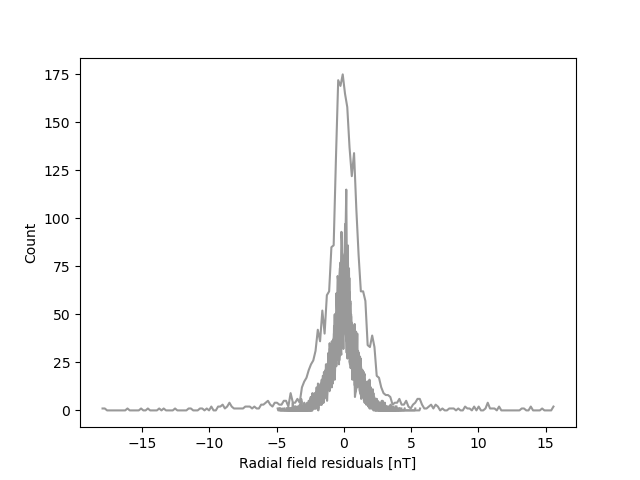

In [27]:
seqsim_pred = G_d*zs
seqsim_res = s_sat.data.reshape(-1,1) - seqsim_pred

rmse_leg = np.sqrt(np.mean(np.power(seqsim_res,2),axis=0))
print("")
print("Seqsim RMSE:\t {}".format(rmse_leg))

color_rgb = (0.6,0.6,0.6)
plt.figure()
for i in np.arange(0,N_sim):
    y,binEdges=np.histogram(seqsim_res[:,[i]],bins=200)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    if i == 0:
        plt.plot(bincenters,y,'-',color = color_rgb,label='Seqsim')  
    else:
        plt.plot(bincenters,y,'-',color = color_rgb)  
        
plt.xlabel("Radial field residuals [nT]")
plt.ylabel("Count")
plt.show()

<IPython.core.display.Javascript object>


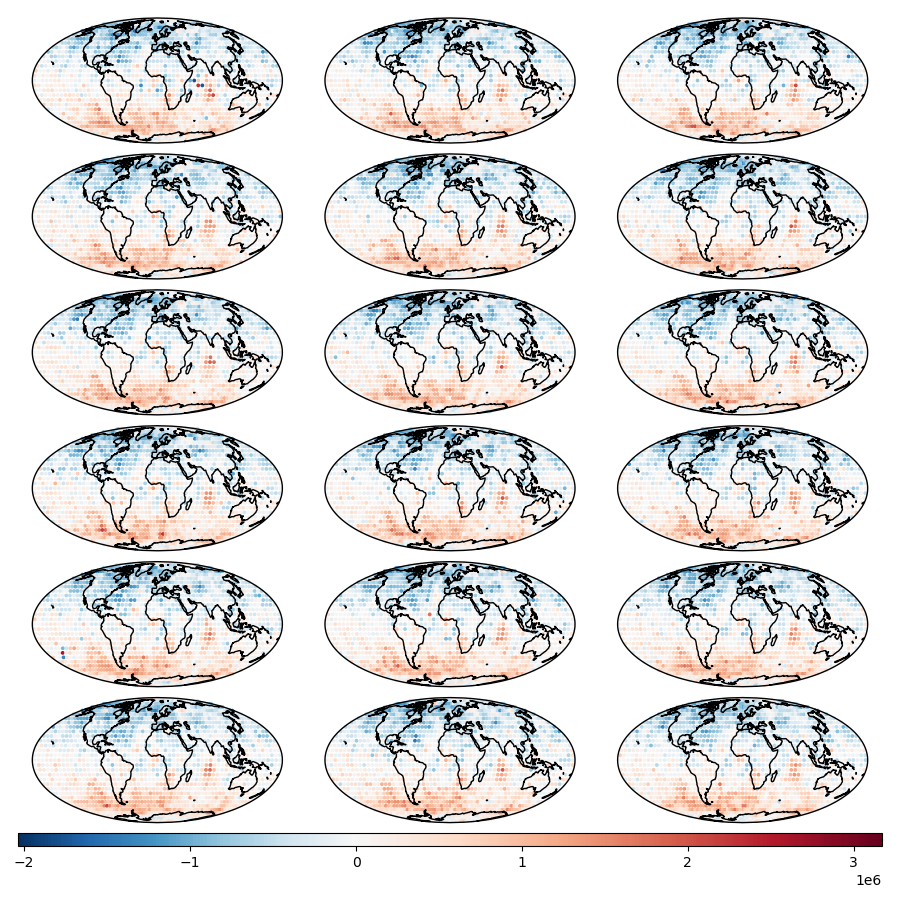

In [28]:
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.lon, core.lat, zs, tile_size_row = 6, tile_size_column = 3, 
                        figsize=(9,9), limit_for_SF = 10**6, shrink_factor = 1.0, point_size = 3,
                        left=0.02, bottom=0.06, right=0.98, top=0.98, wspace = 0.05, hspace=0.1, 
                        savefig = False, save_string = "test", 
                        projection = ccrs.Mollweide())

<IPython.core.display.Javascript object>


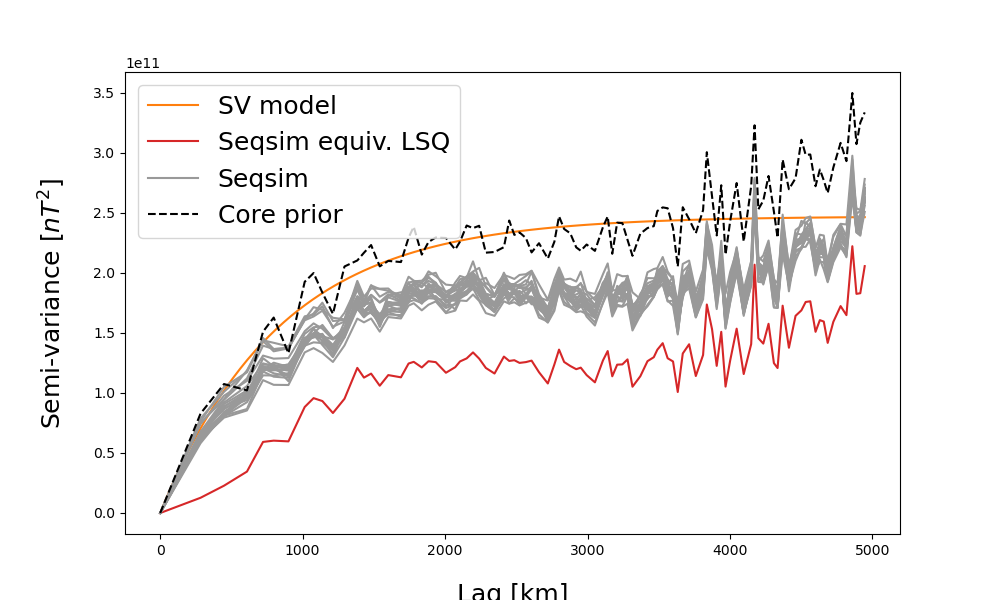

<IPython.core.display.Javascript object>


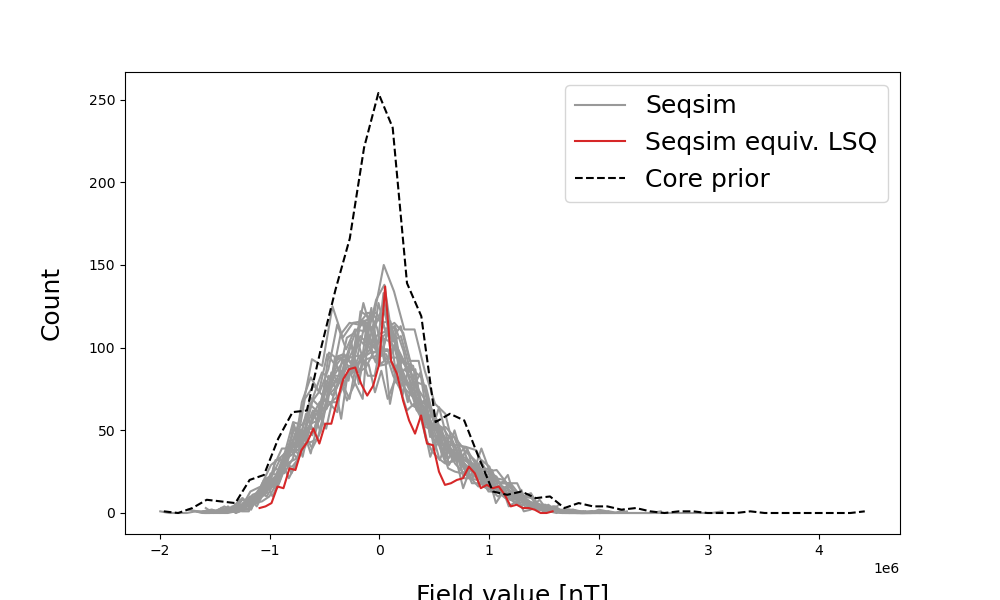

In [32]:
color_rgb = (0.6,0.6,0.6)
bins = 50

#% SEMI-VARIOGRAM
plt.figure(figsize=(10,6))

#plt.plot(core.lags_model,core.pics_model,'.',markersize=10,label='modelling data')

plt.plot(core.lags_sv_curve,core.sv_curve,color='C1',label='SV model')


core.sv_zs(core.grid_glq_N,1,np.array(m_equiv_lsq),core.sort_d,core.n_lags,core.max_cloud)
plt.plot(core.lags,core.pics_zs[:,0],color = 'C3',label='Seqsim equiv. LSQ')    

for i in np.arange(0,N_sim):
    core.sv_zs(core.grid_glq_N,1,zs[:,[i]],core.sort_d,core.n_lags,core.max_cloud)
    if i == 0:
        plt.plot(core.lags,core.pics_zs[:,0],color = color_rgb, label='Seqsim')
    else:
        plt.plot(core.lags,core.pics_zs[:,0],color = color_rgb) 
#print(zs[:,[0]].shape)
#print(core.pics_zs.shape)

#core.sv_zs(core.grid_glq_N,1,data_lstsq["data"].reshape(-1,1),core.sort_d,core.n_lags,core.max_cloud)
#plt.plot(core.lags,core.pics_zs[:,0],color = 'C4',label='LSQ')  

#plt.plot(core.lags,core.pics,'o', markersize=10,color = '0.85',label='Core field estimate')

core.sv_zs(core.grid_glq_N,1,core.data.reshape(-1,1),core.sort_d,core.n_lags,core.max_cloud)
plt.plot(core.lags,core.pics_zs[:,0],'k--',label='Core prior') 

plt.ylabel('Semi-variance $[%s^2]$' % "nT",fontsize=18,labelpad=18)
plt.xlabel('Lag [km]',fontsize=18,labelpad=18)
plt.legend(loc='best',fontsize=18)
plt.show()

#% HISTOGRAM
plt.figure(figsize=(10,6))     

for i in np.arange(0,N_sim):
    y,binEdges=np.histogram(zs[:,[i]],bins=bins,density=False)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    if i == 0:
        plt.plot(bincenters,y,'-',color = color_rgb,label='Seqsim')  
    else:
        plt.plot(bincenters,y,'-',color = color_rgb)   

#y,binEdges=np.histogram(data_lstsq["data"].reshape(-1,1),bins=50,density=False)
#bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
#plt.plot(bincenters,y,'-',color = 'C4',label='LSQ')    

y,binEdges=np.histogram(np.array(m_equiv_lsq),bins=bins,density=False)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-',color = 'C3',label='Seqsim equiv. LSQ') 

y,binEdges=np.histogram(core.data,bins=bins,density=False)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'k--',label='Core prior')

plt.legend(loc='best',fontsize=18)
plt.xlabel('Field value %s' % "[nT]",fontsize=18,labelpad=18)
plt.ylabel('Count',fontsize=18,labelpad=18)
plt.show()

In [33]:
g_spec = []

for i in np.arange(0,N_sim):

    C_cilm = pyshtools.expand.SHExpandGLQ(zs[:,[i]].reshape(core.grid_glq_nmax+1,2*core.grid_glq_nmax+1), core.grid_glq_w_shtools, core.grid_glq_zero, [2, 1, core.grid_glq_nmax])
    nm_C = mt_util.array_nm(core.grid_glq_nmax)

    C_corr_sh = 1/(nm_C[:,[0]]+1)*1/(core.a/core.r_cmb)**(nm_C[:,[0]]+2)
    
    C_index = np.transpose(pyshtools.shio.SHCilmToCindex(C_cilm))
    C_index = C_index[1:,:]*C_corr_sh

    C_vec = mt_util.gauss_vector(C_index, core.grid_glq_nmax, i_n = 0, i_m = 1)
    
    g_spec.append(C_vec)

g_spec = np.array(g_spec).T
print(g_spec.shape)

(960, 20)


In [34]:
g_spec[:3,:10]

array([[-51832.01436532, -51832.88656979, -51831.70610915,
        -51831.23740281, -51832.56898344, -51832.78210839,
        -51832.80344548, -51830.78174791, -51832.69316176,
        -51832.41003792],
       [  3138.65521339,   3138.76879543,   3138.80659929,
          3138.67666022,   3138.7760521 ,   3138.7909285 ,
          3138.77585857,   3138.79211245,   3138.74497036,
          3138.68656474],
       [   680.40624627,    680.2749572 ,    680.08479583,
           680.38959703,    680.25048347,    680.31654329,
           680.39207853,    680.17389174,    680.06440126,
           680.3771279 ]])

In [37]:
core.g_prior[:3]

array([-51832.174  ,   3138.7632 ,    680.29256])

<IPython.core.display.Javascript object>


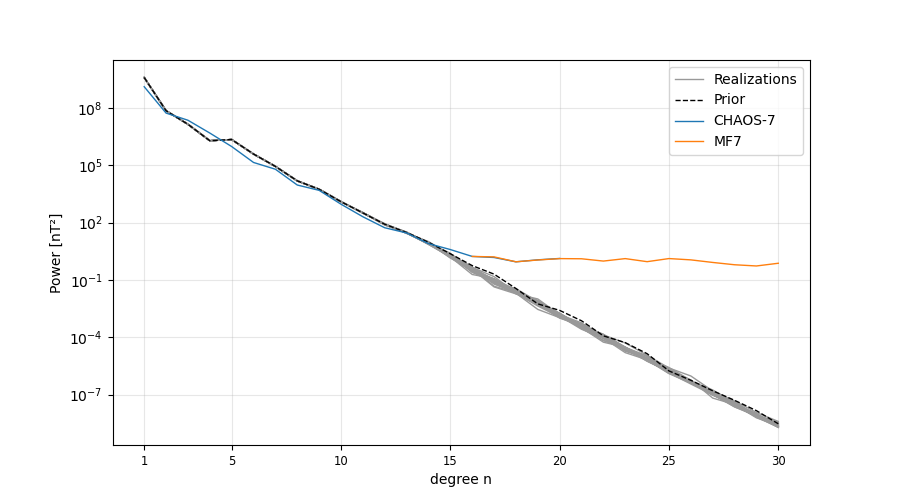

In [36]:
g_spec_compares = core.g_prior
model_dict = {"CHAOS-7", "MF7"}
labels = ["Realization"]

mt_util.plot_p_spec(g_spec, core.r_sat, core.grid_glq_nmax, spec_style = "ensemble",
                    g_spec_compares = g_spec_compares,
                    model_dict = model_dict, label = "Realizations", label_compare = "Prior",
                    lwidth = 1, lwidth_m = 1, figsize = (9,5), color = (0.6, 0.6, 0.6))

In [ ]:
del core.CQF_dist
del core.CQF_mean
del core.CQF_var
del core.sph_d
del core.sv_lut

In [ ]:
# SAVE RESULT
print("\nSaving job")
file_clip = open("core_{}.obj".format(nb_name), "wb")
pickle.dump(core, file_clip, protocol=4)
file_clip.close()

file_clip = open("sat_{}.obj".format(nb_name), "wb")
pickle.dump(s_sat, file_clip, protocol=4)
file_clip.close()
print("\nJob saved and finished")

In [38]:
core.grid_equal_area(N_grid = 15020, r_at = core.r_cmb, poles_remove = True)

core.ensemble_B(g_spec, nmax = core.grid_glq_nmax, r_at = core.r_cmb, grid_type = "eqa")


___ CHANGES TO GRID ___
N = 15020, not compatible for equal area grid
N has been set to 15014


<IPython.core.display.Javascript object>


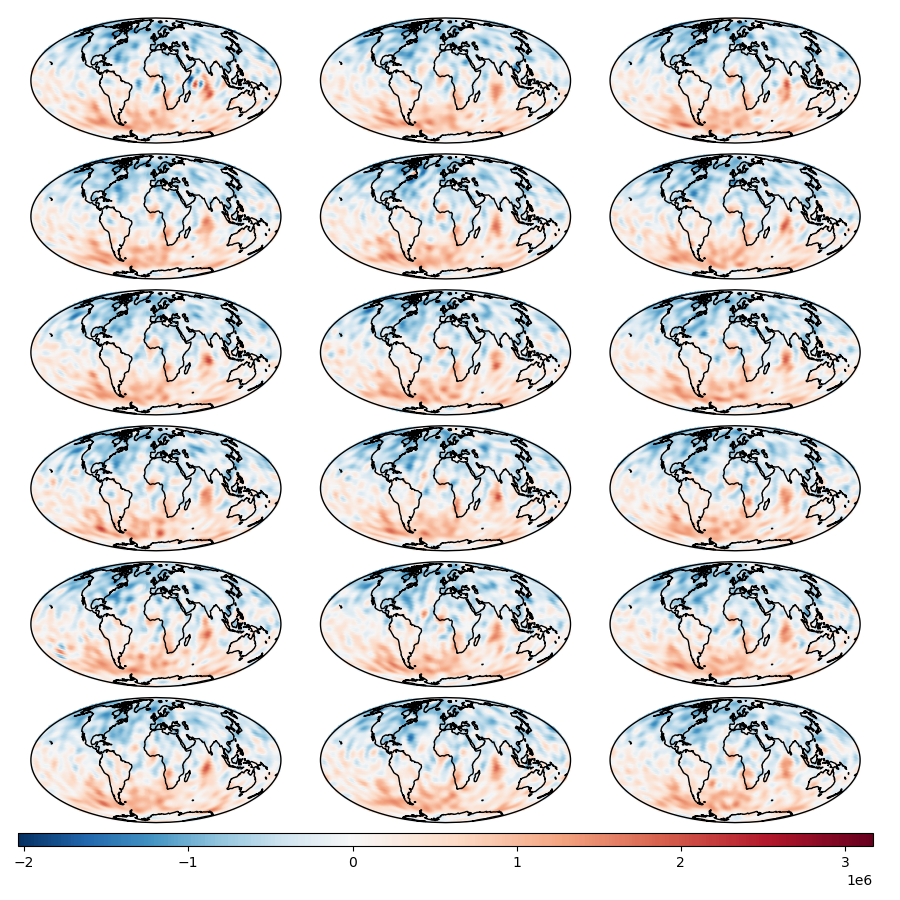

In [39]:
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.grid_eqa_phi, 90-core.grid_eqa_theta, core.B_ensemble_eqa[:,0,:], 
                        field_compare = zs, tile_size_row = 6, tile_size_column = 3, 
                        figsize=(9,9), limit_for_SF = 10**6, shrink_factor = 1.0, point_size = 3,
                        left=0.02, bottom=0.06, right=0.97, top=0.98, wspace = 0.05, hspace=0.1, 
                        savefig = False, save_string = "test", 
                        projection = ccrs.Mollweide())

In [58]:
# Reload plot module when making small changes
#import importlib
#importlib.reload(mt_util)